# Project Overview: Predicting Exoplanet Radius

## Introduction

This project aims to predict the radius of exoplanets using various machine learning models to decipher which model would predict the most accurately. Basic machine learning models were used as further techniques would have been overkill. Accurate prediction of exoplanet characteristics, such as radius, is crucial for understanding their composition, formation, and potential habitability. While radius alone cannot determine these characteristics, it can provide another lead. By leveraging data from exoplanet observations, we can build models that help in the characterization and classification of these distant worlds.

## Dataset

The dataset used in this project contains various features related to exoplanets and their host stars. Key features include orbital period, mass of the planet, eccentricity of the orbit, effective temperature of the star, radius of the star, mass of the star, and the ratio of planet mass to star mass. The target variable is the planet radius (`pl_rade`). The dataset was produced by NASA and their exoplanet archive located at https://exoplanetarchive.ipac.caltech.edu/docs/data.html

## Data Loading and Initial Exploration

### Import Libraries
In this section, we import all necessary libraries required for data loading, preprocessing, visualization, and modeling. The libraries include:
- `numpy` and `pandas` for data manipulation.
- `sklearn` for machine learning models and preprocessing.
- `matplotlib` and `seaborn` for data visualization.
- `xgboost` and `tpot` for advanced modeling techniques.
- `missingno` for visualizing missing data.
- `scipy` for statistical computations.
- `tensorflow` for utilization of Nvidia cuDNN libraries.

## Loading Dataset
We renamed the dataset file to 'planetarySystems.csv' for simplicity sake. The dataset planetarySystems.csv is loaded into a pandas dataframe. Initial exploration includes displaying the first few rows of the dataset and providing a summary of the dataset’s structure and statistics

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
import missingno as msno
from scipy.stats import zscore
from tpot import TPOTRegressor
import math
os.environ['TF_FORCE_DIRECTML'] = '1'

# Make sure TensorFlow can access the GPU
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow GPU devices: ", tf.config.list_physical_devices('GPU'))

# Load dataset
file_path = 'planetarySystems.csv'
data = pd.read_csv(file_path, comment='#')

# Display the first few rows and dataset info
print(data.head())
print(data.info())

print("\nSummary Statistics:")
print(data.describe())


TensorFlow version: 2.10.0
Num GPUs Available:  1
TensorFlow GPU devices:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
      pl_name  hostname  sy_snum  sy_pnum  discoverymethod  disc_year  \
0    11 Com b    11 Com        2        1  Radial Velocity       2007   
1    11 UMi b    11 UMi        1        1  Radial Velocity       2009   
2    14 And b    14 And        1        1  Radial Velocity       2008   
3    14 Her b    14 Her        1        2  Radial Velocity       2002   
4  16 Cyg B b  16 Cyg B        3        1  Radial Velocity       1996   

                            disc_facility  pl_controv_flag   pl_orbper  \
0                        Xinglong Station                0   323.21000   
1  Thueringer Landessternwarte Tautenburg                0   516.21997   
2       Okayama Astrophysical Observatory                0   186.76000   
3                  W. M. Keck Observatory                0  1765.03890   
4                  Multiple Observatories        

## Initial Data Analysis

According to the columns, there are 83 columns/features. Using this many features to predict planet radius can create a plethora of issues ranging from computational speed to overfitting. Later in this notebook, you will be able to view the process of our methodology for feature selection.

## Missing Values

Missing values are a common issue in datasets. This section checks for missing values for all the features, visualizes them, and provides a summary:

	•	Missing Values Heatmap: A heatmap to show the pattern of missing data across different features.
	•	Missing Values Bar Plot: A bar plot to show the number of missing values per column.
	•	Missing Values Summary: A printed summary of the columns with missing values and their counts.

<Figure size 1500x1000 with 0 Axes>

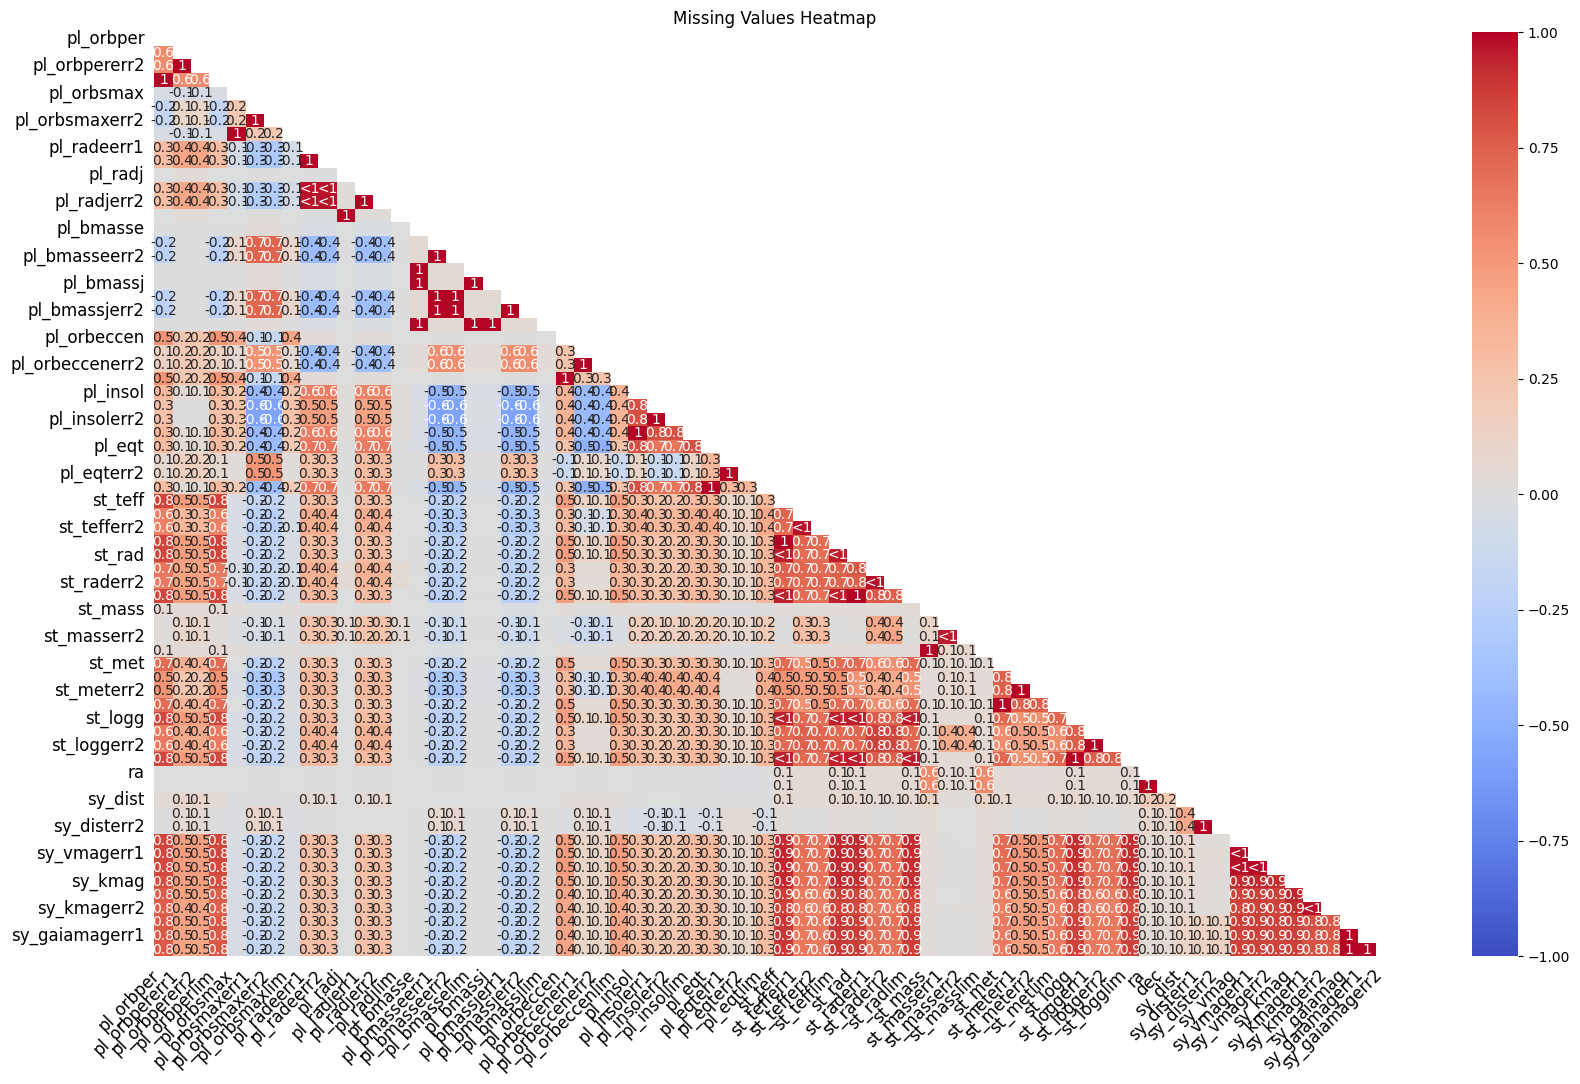

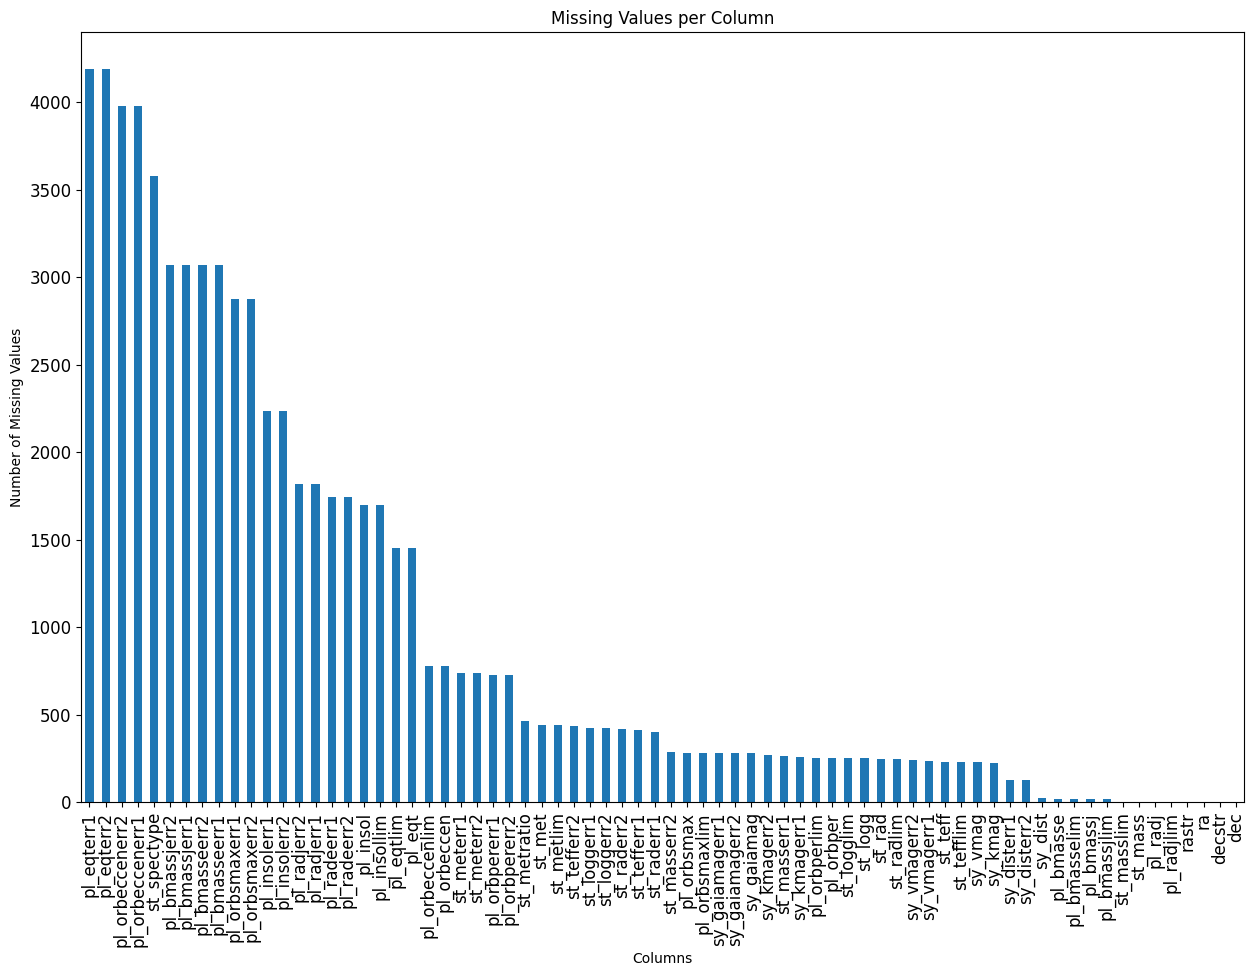


Missing Values Summary:
pl_eqterr1         4190
pl_eqterr2         4190
pl_orbeccenerr2    3979
pl_orbeccenerr1    3979
st_spectype        3577
                   ... 
pl_radjlim            1
rastr                 1
ra                    1
decstr                1
dec                   1
Length: 72, dtype: int64


In [5]:
# Check for missing values
missing_values = data.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]

# Select only numeric columns and drop rows with non-numeric values
numeric_data = data.select_dtypes(include=[np.number])

# Plot Missing Values Heatmap
plt.figure(figsize=(15, 10))
msno.heatmap(numeric_data, fontsize=12, cmap='coolwarm')
plt.title('Missing Values Heatmap')
plt.show()

# Plot Missing Values per Column
plt.figure(figsize=(15, 10))
missing_values.plot(kind='bar', fontsize=12)
plt.title('Missing Values per Column')
plt.ylabel('Number of Missing Values')
plt.xlabel('Columns')
plt.show()

# Print Missing Values Summary
print("\nMissing Values Summary:")
print(missing_values)

## Analysis of Missing Values

According to the missing values summary, the top 5 features for missing values hover around 4000 and with the amount of features in the dataset, it makes the heatmap difficult to descipher. Planet orbital period upper and lower uncertainty features are missing a lot of values and the same with planet orbital eccentricity upper and lower uncertainty features. However, what features actually matter in terms of correlation with planet radius? We can drop values all day but if they have very minimal correlation to planet radius, there will be no progress made.

## Correlations

Instead, we decided to pick out the features most correlated with planet radius and then drop their values. With the code below, we selected only numeric data to view the correlations. While non-numeric data could also potentially improve the model later down the notebook, that would require encoding. For the sake of simplicity, we stayed with numeric data. First a standard correlation matrix is printed and then, the features that correlate with planet radius the most are then extracted and plotted.

Correlation Matrix:
                  sy_snum   sy_pnum  disc_year  pl_controv_flag  pl_orbper  \
sy_snum          1.000000 -0.048605  -0.152663        -0.047122  -0.073204   
sy_pnum         -0.048605  1.000000  -0.041684         0.167604  -0.084940   
disc_year       -0.152663 -0.041684   1.000000         0.009526  -0.140849   
pl_controv_flag -0.047122  0.167604   0.009526         1.000000   0.017183   
pl_orbper       -0.073204 -0.084940  -0.140849         0.017183   1.000000   
...                   ...       ...        ...              ...        ...   
sy_kmagerr1     -0.052385  0.251231  -0.113997         0.310937   0.007457   
sy_kmagerr2      0.052385 -0.251231   0.113997        -0.310937  -0.007457   
sy_gaiamag      -0.053279  0.010036  -0.279211        -0.176972   0.118241   
sy_gaiamagerr1   0.122791  0.351520  -0.073210         0.129057  -0.139221   
sy_gaiamagerr2  -0.122791 -0.351520   0.073210        -0.129057   0.139221   

                 pl_orbpererr1  pl_orbperer

C:\Users\skyle\AppData\Local\Temp\ipykernel_13212\445905061.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=correlation_with_rade.index, x=correlation_with_rade['pl_rade'], palette='coolwarm')


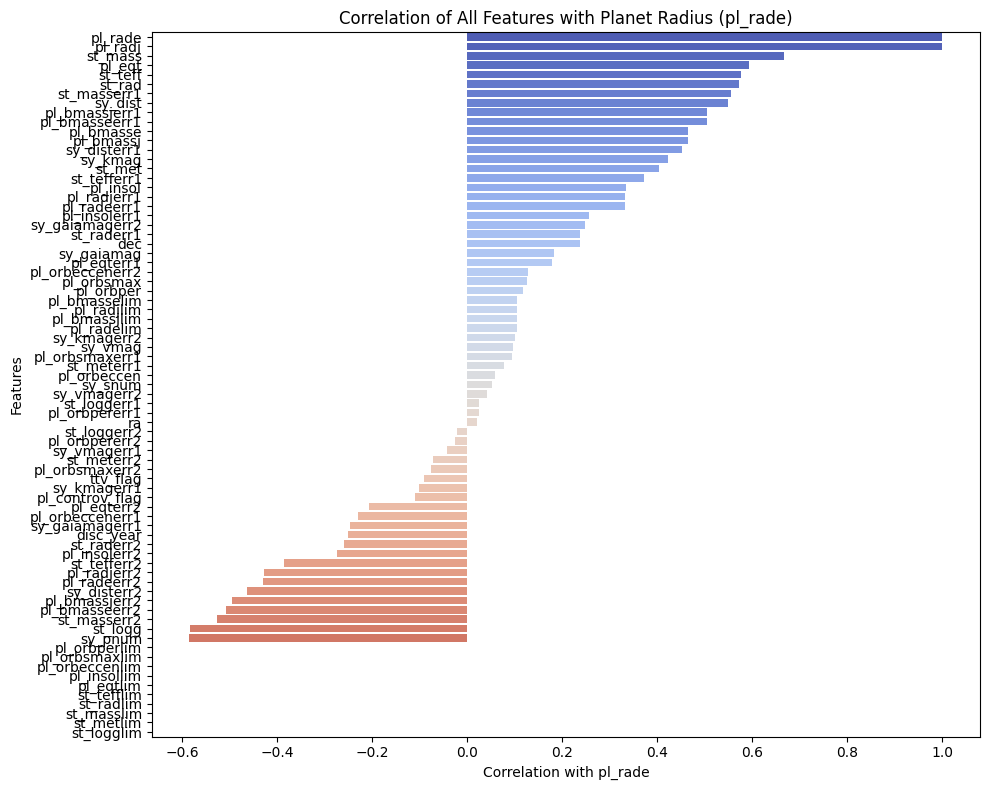

In [6]:
# Select only numeric columns
numeric_data = data.select_dtypes(include=[float, int])

# Fill or drop missing values
numeric_data = numeric_data.dropna()

# Calculate the correlation matrix for all features
correlation_matrix = numeric_data.corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Extract correlations with 'pl_rade'
correlation_with_rade = correlation_matrix[['pl_rade']].sort_values(by='pl_rade', ascending=False)

# Set display options to show all rows
pd.set_option('display.max_rows', None)

# Print the correlations with 'pl_rade'
print("\nCorrelation with Planet Radius (pl_rade):")
print(correlation_with_rade)

# Plot the correlations with 'pl_rade'
plt.figure(figsize=(10, 8))
sns.barplot(y=correlation_with_rade.index, x=correlation_with_rade['pl_rade'], palette='coolwarm')

plt.title('Correlation of All Features with Planet Radius (pl_rade)')
plt.xlabel('Correlation with pl_rade')
plt.ylabel('Features')

# Adjust the y-axis labels
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()

plt.show()

## Feature Engineering

The code below implements some simple feature engineering. By taking the ratio of planet mass to star mass, a new feature is created. It is then displayed to ensure it was put into the dataframe.

In [7]:
# Create a new feature: ratio of planet mass to star mass
data['pl_mass_to_st_mass'] = data['pl_bmasse'] / data['st_mass']

# Display the first few rows to check the new feature
print(data[['pl_bmasse', 'st_mass', 'pl_mass_to_st_mass']].head())

    pl_bmasse  st_mass  pl_mass_to_st_mass
0  4914.89849     2.09         2351.626072
1  4684.81420     2.78         1685.184964
2  1131.15130     1.78          635.478258
3  2559.47216     0.91         2812.606769
4   565.73740     1.08          523.830926


## Correlation Analysis

To preface this section, features labeled with err followed by a 1 or a 2 means uncertainty. 1 means upper uncertainty while 2 means lower uncertainty. The letter j in the features simply mean in Jupiter units.
As you can tell in the summary printed out or the plot and besides planet radius, 
- **stellar mass** denoted as 'st_mass' (solar masses)
- **stellar radius** denoted as 'st_rad' (solar radii)
- **planet equillibrium temperature** denoted as 'pl_eqt' temperature (K)
- **stellar effective** denoted as 'st_teff' temperature (K)
- **stellar mass upper uncertainty** denoted as 'st_masserr1' (solar masses)
- **system distance** denoted as 'sy_dist' (parsecs)
- **planet mass upper uncertainty** denoted as 'pl_masserr1' (Earth masses)
- Our engineered feature **planet mass to stellar mass** denoted as 'pl_bmass_to_st_mass'
- **planet mass** denoted as 'pl_bmasse' (Earth masses) are all in the top 10 for most correlated to planet radius.

This leads into the next code snippet, the next code snippet is taking all of these highly correlated features to planet radius and making them our selected features.

In [8]:
# Select the features for predicting radius
selected_features = ['st_masserr1', 'sy_dist', 'pl_eqt', 'pl_bmasse', 'pl_bmasseerr1', 'st_teff', 'st_rad', 'st_mass', 'pl_mass_to_st_mass']

## Dropping Selected Features

In the code snippet below, we decided to take a look at the missing values but this time around specifically for our selected features. While not an exorbitant amount of missing values, these still need to be dropped and so they are.

In [9]:
# Ensure the selected features are in the dataset
missing_features = [feature for feature in selected_features if feature not in data.columns]
if missing_features:
    raise ValueError(f"These features are not in the dataset: {missing_features}")

# Check for missing values in the selected features
missing_values = data[selected_features].isnull().sum()

# Print the missing values for each selected feature
print("Missing Values in Selected Features:")
print(missing_values)

data_selected = data[selected_features].dropna()


Missing Values in Selected Features:
st_masserr1            264
sy_dist                 23
pl_eqt                1451
pl_bmasse               16
pl_bmasseerr1         3070
st_teff                228
st_rad                 246
st_mass                  3
pl_mass_to_st_mass      19
dtype: int64


## Histograms of Selected Features

Below, there is code to visualize the data frequency on each of our selected feature with their respective range and units.

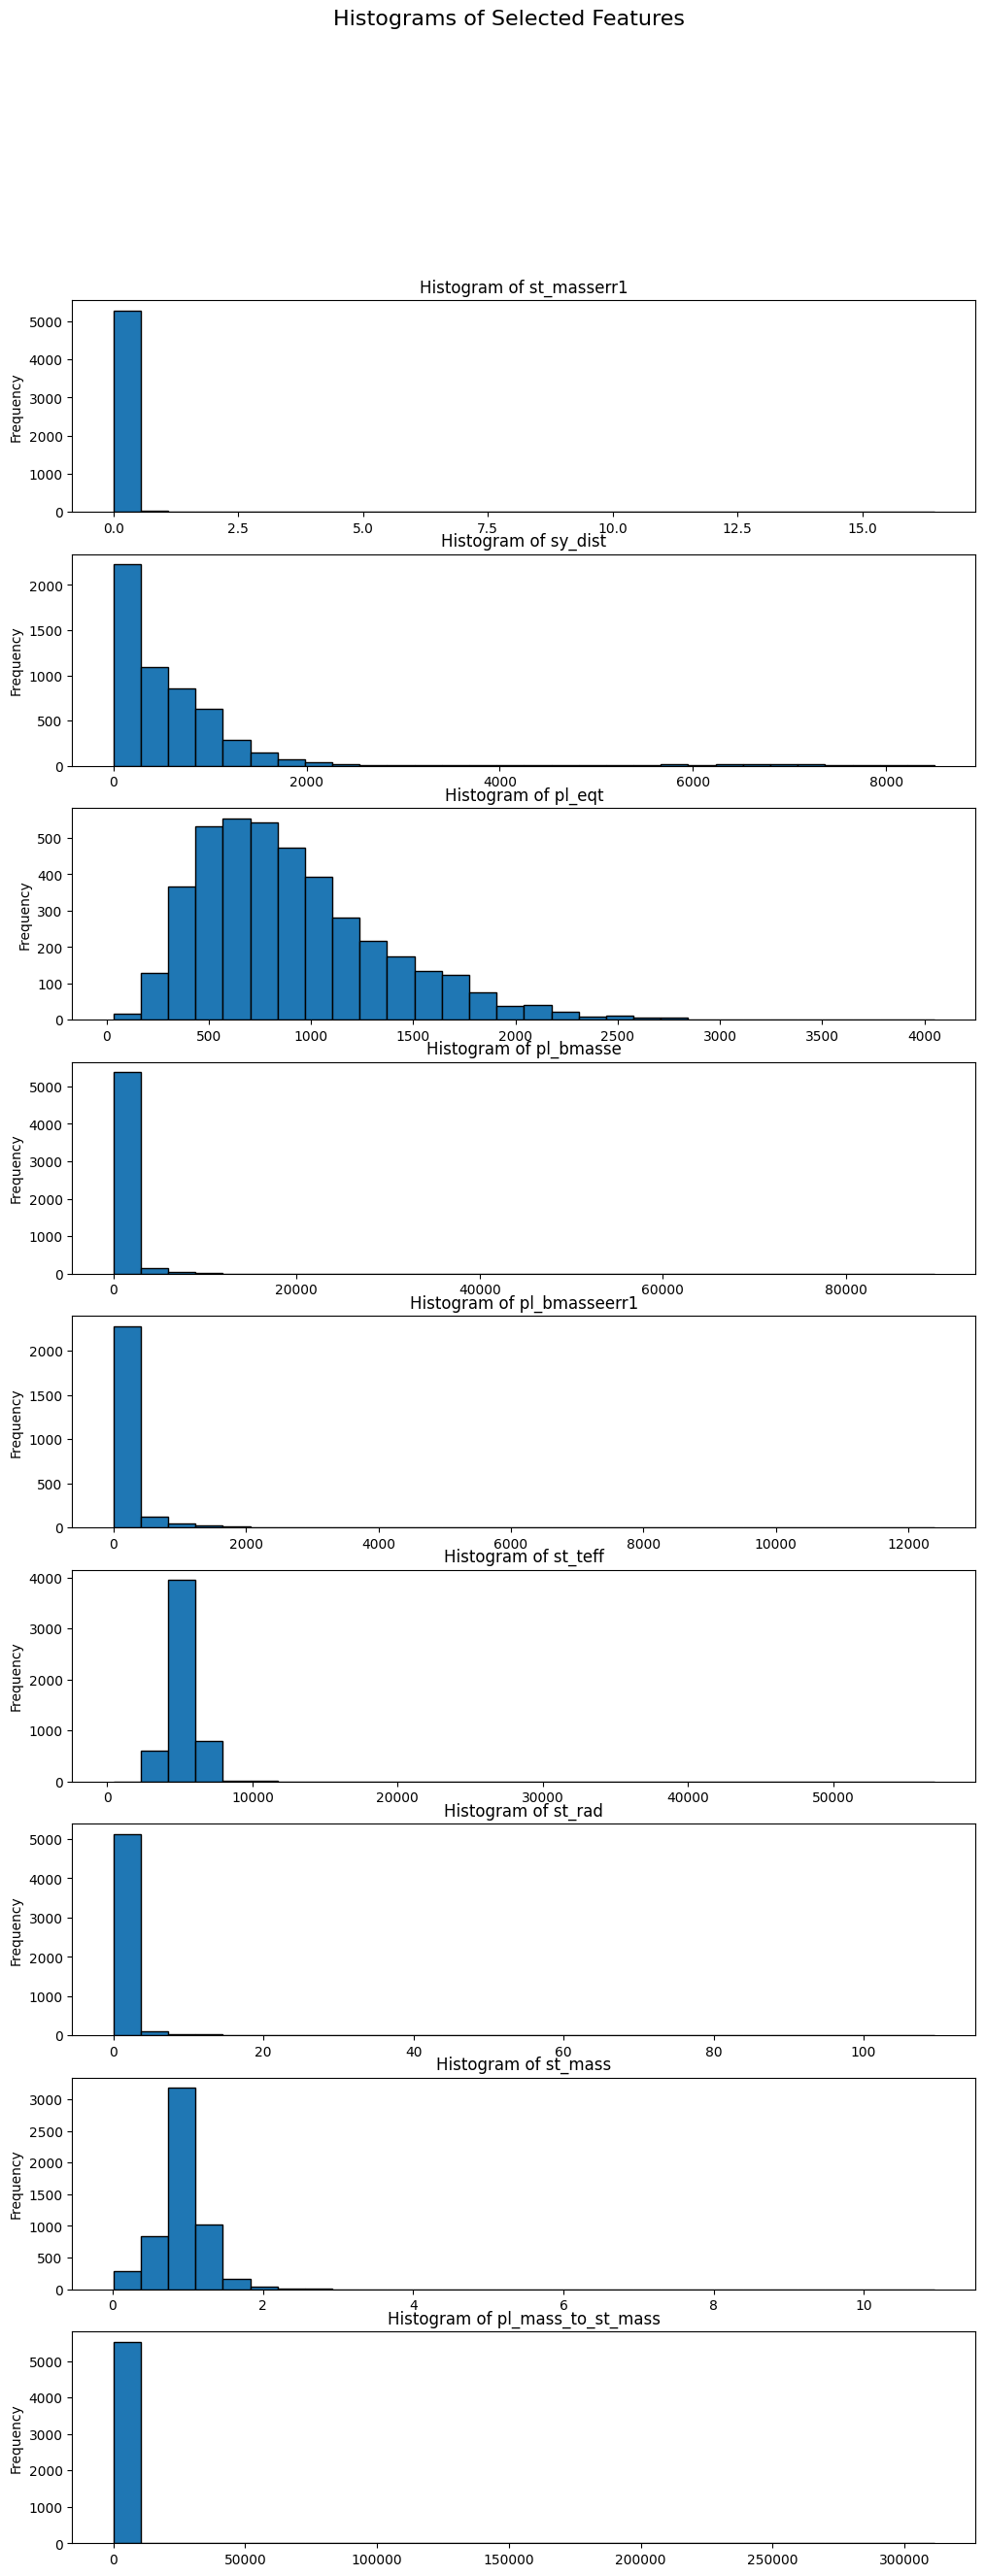

In [10]:
# Data Visualizations for Selected Features

fig, axes = plt.subplots(len(selected_features), 1, figsize=(12, 30))
fig.suptitle('Histograms of Selected Features', fontsize=16)

for ax, feature in zip(axes, selected_features):
    ax.hist(data[feature].dropna(), bins=30, edgecolor='k')
    ax.set_title(f'Histogram of {feature}', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=10)

## Data Analysis of Selected Features

- **Stellar Mass Upper Uncertainty**:
  - Most data entries are in the range of 0-1 solar masses.
  - Values can go up to around 5000 solar masses.

- **System Distance**:
  - Most entries fall within the 0-2000 parsecs range.
  - There are over 2000 entries in this range.

- **Planet Equilibrium Temperature**:
  - Majority of data entries hover around 250-1500 Kelvin.

- **Planet Mass**:
  - Most entries stay around 0-2500 Earth masses.
  - There are approximately 5000 entries in this range.
  - Planet mass upper uncertainty follows a similar distribution.

- **Stellar Effective Temperature**:
  - Majority of observed temperatures are around 5000 Kelvin.

- **Stellar Mass**:
  - Most observed stars have a mass around 5 solar masses.
  - This indicates that these host stars are not much larger than our Sun.


## Outliers

This section of the code focuses on outlier detection and treatment. The steps involved are as follows:

1. **Calculate Z-scores**: For each selected feature, the Z-score is calculated to identify how many standard deviations away each data point is from the mean.

2. **Define the Threshold**: A threshold of 3 is set, meaning any data point with a Z-score greater than 3 or less than -3 is considered an outlier.

3. **Identify Outliers**: Using the defined threshold, the code identifies the outliers for each feature.

4. **Print Number of Outliers**: For each selected feature, the number of identified outliers is printed.

5. **Remove Outliers**: Outliers are removed from the dataset. The cleaned dataset is then used for further analysis.

The cleaned data, with outliers removed, is used for subsequent steps in the analysis.

Below is the code for outlier detection and treatment:

In [11]:
# Outlier Detection and Treatment

# Calculate Z-scores for each feature
z_scores = data[selected_features].apply(zscore)

# Define the threshold for identifying outliers
threshold = 3

# Identify outliers
outliers = (z_scores.abs() > threshold)

# Print the number of outliers for each feature
for feature in selected_features:
    num_outliers = outliers[feature].sum()
    print(f"Number of outliers in {feature}: {num_outliers}")

# Remove outliers
data_cleaned = data[~outliers.any(axis=1)]
print(f"Data shape after removing outliers: {data_cleaned.shape}")

# Use cleaned data for further analysis
data = data_cleaned

Number of outliers in st_masserr1: 0
Number of outliers in sy_dist: 0
Number of outliers in pl_eqt: 0
Number of outliers in pl_bmasse: 0
Number of outliers in pl_bmasseerr1: 0
Number of outliers in st_teff: 0
Number of outliers in st_rad: 0
Number of outliers in st_mass: 0
Number of outliers in pl_mass_to_st_mass: 0
Data shape after removing outliers: (5596, 85)


## Outlier Analysis

This section of the code prepares the data for machine learning modeling by performing several preprocessing steps. The steps we took are as follows:

1. **Drop Rows with Missing Target Values**: Rows where the target variable `pl_rade` is NaN are dropped from the dataset.

2. **Define Features and Target Variable**: The features (`X`) and the target variable (`y`) are defined. The selected features are `pl_orbeccen`, `st_mass`, `pl_orbper`, `pl_bmasse`, `st_teff`, and `st_rad`.

3. **Split the Data**: The dataset is split into training and testing sets, with 80% of the data used for training and 20% for testing.

4. **Impute Missing Values**: Missing values in the feature set are imputed using the mean strategy.

5. **Scale the Features**: The features are scaled to have a mean of 0 and a standard deviation of 1.

6. **Create Polynomial Features**: Polynomial features are created to capture interactions between features and add non-linearity to the model.

7. **Apply PCA**: Principal Component Analysis (PCA) is applied to reduce the dimensionality of the data. The number of components is adjusted based on the explained variance.

8. **Plot Explained Variance**: The explained variance by the number of components is plotted to help determine the optimal number of components to retain.

Below is the code for data preprocessing and preparation:

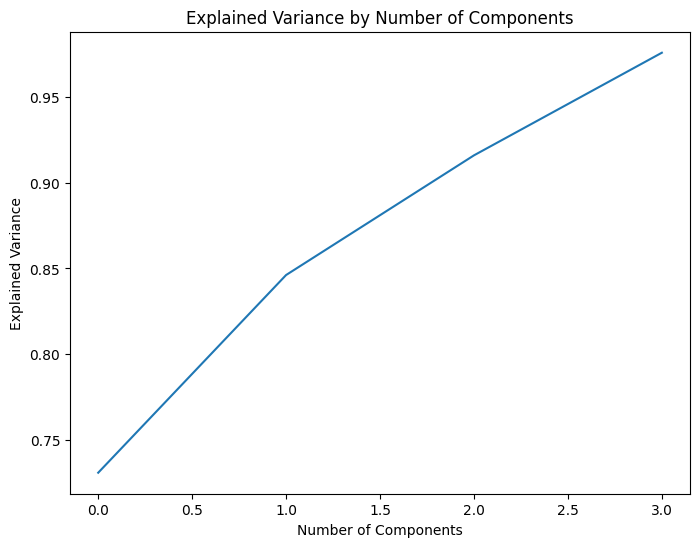

In [12]:
# Drop rows where the target 'pl_rade' is NaN
data = data.dropna(subset=['pl_rade'])

# Define the features and target variable
X = data[['pl_orbeccen', 'st_mass', 'pl_orbper', 'pl_bmasse', 'st_teff', 'st_rad']]
y = data['pl_rade']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values in the features
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Apply PCA
pca = PCA(n_components=4)  # Adjust the number of components based on explained variance
X_train_pca = pca.fit_transform(X_train_poly)
X_test_pca = pca.transform(X_test_poly)

plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.show()

## PCA

According to the plot above, PCA took linear combinations of all the features leading to the number of components/features that capture 90% of the data is about 2. This means that the reduction of the dimensions is successful which increases efficiency and reducing needed computational power.

## Model Training and Tuning (The Good Stuff)

This section of the code focuses on hyperparameter tuning, model evaluation, and visualization. With the amount of models available, it was decided that trying multiple models to compare would be an interesting step forward to take. The methodology is as follows:

1. **Hyperparameter Tuning for RandomForestRegressor**:
   - Define the parameter grid for the RandomForestRegressor.
   - Perform grid search with cross-validation to find the best hyperparameters.
   - Evaluate the best model on the test set and print the Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R² score.

2. **Hyperparameter Tuning for XGBoost**:
   - Define the parameter grid for the XGBoost Regressor.
   - Perform grid search with cross-validation to find the best hyperparameters.
   - Evaluate the best model on the test set and print the MSE, RMSE, and R² score.
   - Perform cross-validation to calculate the average RMSE.

3. **Training Other Models for Comparison**:
   - Train and evaluate various regression models including Linear Regression, Ridge Regression, Lasso Regression, and Gradient Boosting.
   - Print the MSE, RMSE, and R² score for each model.

4. **Feature Importance from the Best XGBoost Model**:
   - Use the best XGBoost model to determine feature importances.
   - Visualize the feature importances using a bar plot.

5. **Visualize Actual vs. Predicted Values**:
   - Plot the actual vs. predicted planet radius for both Random Forest and XGBoost models.
   - Include an ideal fit line for comparison.

6. **Print Sample of Actual vs. Predicted Values**:
   - Print a sample of actual vs. predicted values for both Random Forest and XGBoost models.

Below is the code for hyperparameter tuning, model evaluation, and visualization:

Random Forest Regressor:
 MSE: 3.85, RMSE: 1.96, R²: 0.86
XGBoost Regressor:
 MSE: 2.80, RMSE: 1.67, R²: 0.90
Average RMSE from 10-Fold Cross-Validation: 1.77
Linear Regression:
 MSE: 58.60, RMSE: 7.66, R²: -1.16
Ridge Regression:
 MSE: 35.03, RMSE: 5.92, R²: -0.29
Lasso Regression:
 MSE: 23.22, RMSE: 4.82, R²: 0.14
Gradient Boosting:
 MSE: 5.61, RMSE: 2.37, R²: 0.79


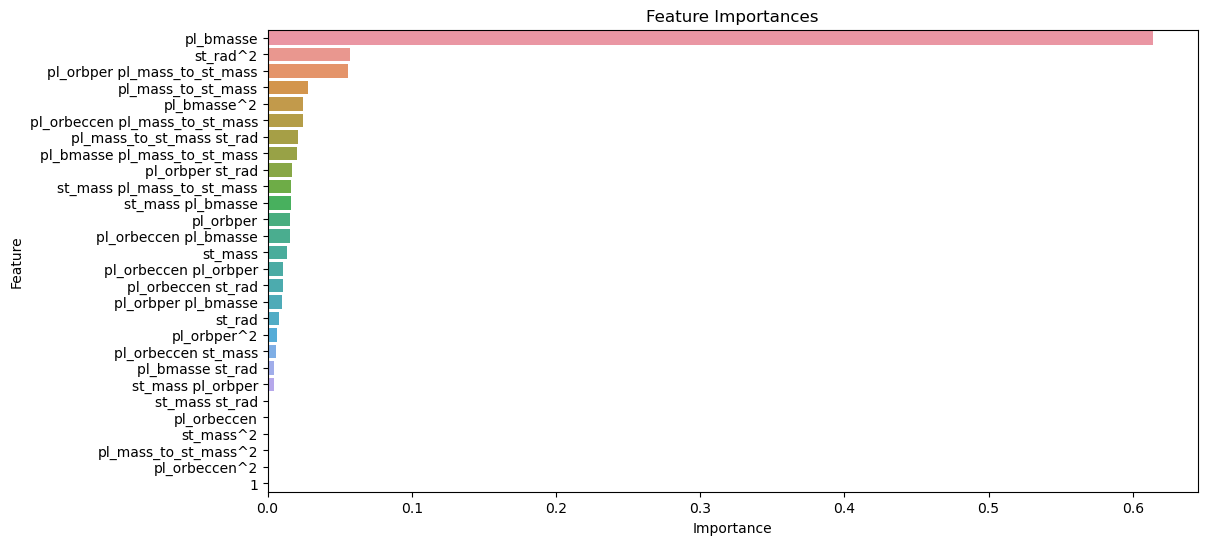

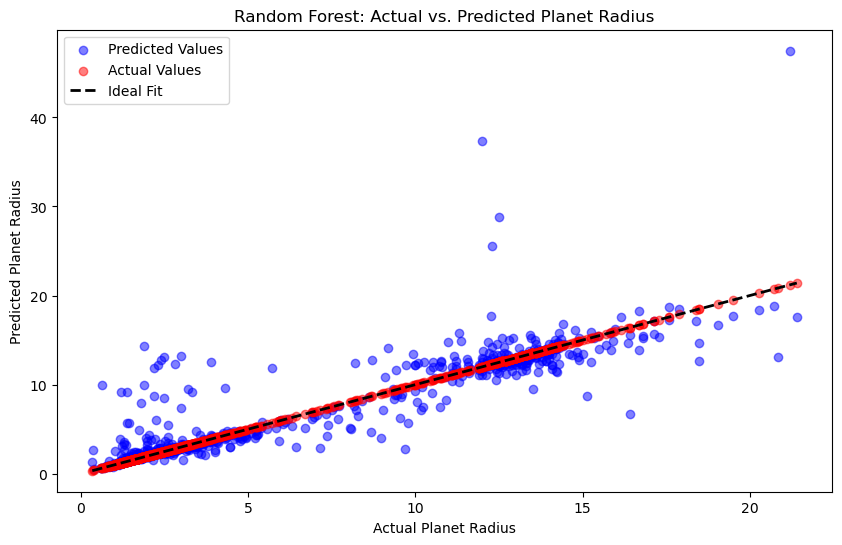

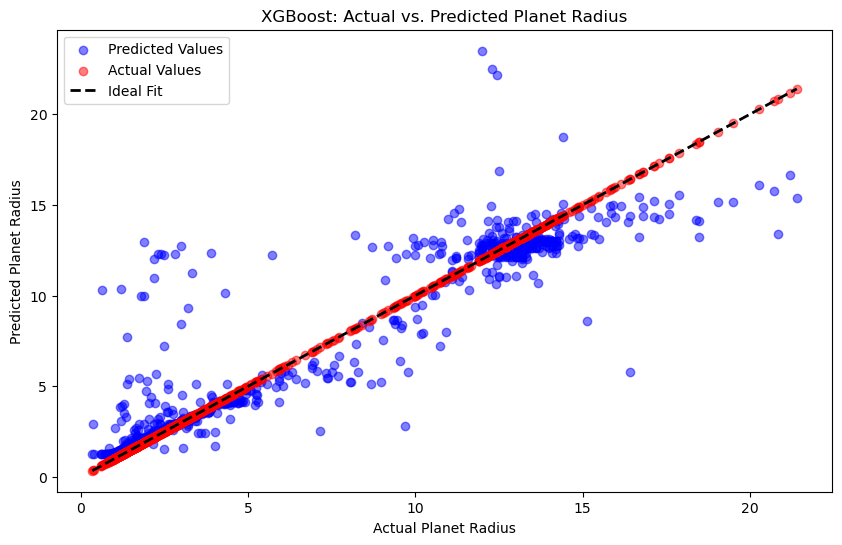


Sample of Actual vs. Predicted Values (Random Forest):
Actual: 2.17, Predicted: 2.16
Actual: 11.10, Predicted: 11.93
Actual: 2.61, Predicted: 2.50
Actual: 2.31, Predicted: 2.41
Actual: 12.90, Predicted: 11.55
Actual: 13.30, Predicted: 13.25
Actual: 2.70, Predicted: 2.70
Actual: 1.79, Predicted: 1.81
Actual: 3.48, Predicted: 3.03
Actual: 15.82, Predicted: 15.81

Sample of Actual vs. Predicted Values (XGBoost):
Actual: 2.17, Predicted: 2.35
Actual: 11.10, Predicted: 11.94
Actual: 2.61, Predicted: 2.67
Actual: 2.31, Predicted: 2.53
Actual: 12.90, Predicted: 11.90
Actual: 13.30, Predicted: 12.92
Actual: 2.70, Predicted: 2.79
Actual: 1.79, Predicted: 1.97
Actual: 3.48, Predicted: 3.09
Actual: 15.82, Predicted: 14.96


In [14]:
# Hyperparameter tuning for RandomForestRegressor
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30]
}
rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train_poly, y_train)

best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_poly)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Regressor:\n MSE: {mse_rf:.2f}, RMSE: {rmse_rf:.2f}, R²: {r2_rf:.2f}")

# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X_train_poly, y_train)

best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_poly)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Regressor:\n MSE: {mse_xgb:.2f}, RMSE: {rmse_xgb:.2f}, R²: {r2_xgb:.2f}")

# Cross-validation score for the best XGBoost model
scores = cross_val_score(best_xgb, X_train_poly, y_train, cv=10, scoring='neg_mean_squared_error')
avg_rmse = np.sqrt(-scores.mean())
print(f"Average RMSE from 10-Fold Cross-Validation: {avg_rmse:.2f}")

# Training other models for comparison
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2)),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}:\n MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Feature Importance from the best XGBoost model
# Create the PolynomialFeatures object
poly = PolynomialFeatures(degree=2)

# Fit to the original training features to get the feature names
poly.fit(X_train_scaled)

# Get the feature names
features = poly.get_feature_names_out(input_features=['pl_orbeccen', 'st_mass', 'pl_orbper', 'pl_bmasse', 'pl_mass_to_st_mass', 'st_rad'])

# Get feature importances from the best XGBoost model
feature_importances = best_xgb.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

# Visualize Actual vs. Predicted Values for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, label='Predicted Values', color='blue')
plt.scatter(y_test, y_test, alpha=0.5, label='Actual Values', color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Planet Radius')
plt.ylabel('Predicted Planet Radius')
plt.title('Random Forest: Actual vs. Predicted Planet Radius')
plt.legend()
plt.show()

# Visualize Actual vs. Predicted Values for XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, label='Predicted Values', color='blue')
plt.scatter(y_test, y_test, alpha=0.5, label='Actual Values', color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Planet Radius')
plt.ylabel('Predicted Planet Radius')
plt.title('XGBoost: Actual vs. Predicted Planet Radius')
plt.legend()
plt.show()

# Print actual vs. predicted values for a sample (Random Forest)
print("\nSample of Actual vs. Predicted Values (Random Forest):")
for actual, predicted in zip(y_test[:10], y_pred_rf[:10]):
    print(f"Actual: {actual:.2f}, Predicted: {predicted:.2f}")

# Print actual vs. predicted values for a sample (XGBoost)
print("\nSample of Actual vs. Predicted Values (XGBoost):")
for actual, predicted in zip(y_test[:10], y_pred_xgb[:10]):
    print(f"Actual: {actual:.2f}, Predicted: {predicted:.2f}")

### Model Performance Analysis

#### Random Forest Regressor
- **MSE**: 3.85
- **RMSE**: 1.96
- **R²**: 0.86

The Random Forest Regressor shows a good performance with an R² of 0.86, indicating that 86% of the variance in the target variable can be explained by the model. The RMSE of 1.96 suggests that the average prediction error is relatively low.

#### XGBoost Regressor
- **MSE**: 2.80
- **RMSE**: 1.67
- **R²**: 0.90
- **Average RMSE from 10-Fold Cross-Validation**: 1.77

XGBoost Regressor outperforms the Random Forest with a higher R² of 0.90, explaining 90% of the variance in the target variable. The RMSE of 1.67 is lower than that of the Random Forest, indicating better predictive accuracy. The average RMSE from 10-fold cross-validation is 1.77, suggesting consistent performance across different subsets of the data.

#### Other Models for Comparison
- **Linear Regression**:
  - **MSE**: 58.60
  - **RMSE**: 7.66
  - **R²**: -1.16
- **Ridge Regression**:
  - **MSE**: 35.03
  - **RMSE**: 5.92
  - **R²**: -0.29
- **Lasso Regression**:
  - **MSE**: 23.22
  - **RMSE**: 4.82
  - **R²**: 0.14
- **Gradient Boosting**:
  - **MSE**: 5.61
  - **RMSE**: 2.37
  - **R²**: 0.79

The linear regression and regularized models (Ridge and Lasso) perform poorly compared to Random Forest and XGBoost, with higher MSE and RMSE values, and much lower R² scores. Gradient Boosting performs better than these but still lags behind XGBoost and Random Forest.

### Visualizations

#### Feature Importances (XGBoost)

The feature importance plot indicates that `pl_bmasse` (planet mass) is by far the most important feature for predicting planet radius. Other significant features include `st_rad` (stellar radius) and various polynomial interaction terms involving `pl_orbper` (orbital period) and `pl_mass_to_st_mass` (planet mass to stellar mass ratio).

#### Actual vs. Predicted Values

The scatter plots of actual vs. predicted values for both Random Forest and XGBoost show a strong linear relationship along the ideal fit line, indicating that both models are predicting reasonably well. However, XGBoost appears to have a tighter clustering around the ideal fit line, reflecting its better performance metrics.

### Sample of Actual vs. Predicted Values

#### Random Forest
| Actual | Predicted |
|--------|------------|
| 2.17   | 2.16       |
| 11.10  | 11.93      |
| 2.61   | 2.50       |
| 2.31   | 2.41       |
| 12.90  | 11.55      |
| 13.30  | 13.25      |
| 2.70   | 2.70       |
| 1.79   | 1.81       |
| 3.48   | 3.03       |
| 15.82  | 15.81      |

#### XGBoost
| Actual | Predicted |
|--------|------------|
| 2.17   | 2.35       |
| 11.10  | 11.94      |
| 2.61   | 2.67       |
| 2.31   | 2.53       |
| 12.90  | 11.90      |
| 13.30  | 12.92      |
| 2.70   | 2.79       |
| 1.79   | 1.97       |
| 3.48   | 3.09       |
| 15.82  | 14.96      |

The samples of actual vs. predicted values for both Random Forest and XGBoost show that predictions are quite close to the actual values, with XGBoost generally providing slightly more accurate predictions.


In [4]:
from tpot import TPOTRegressor

# Initialize the TPOT Regressor
tpot = TPOTRegressor(verbosity=2, generations=5, population_size=50, random_state=42)

# Fit the TPOT model on the training data
tpot.fit(X_train_poly, y_train)

# Predict on the test data
y_pred_tpot = tpot.predict(X_test_poly)

# Evaluate the TPOT model
mse_tpot = mean_squared_error(y_test, y_pred_tpot)
rmse_tpot = np.sqrt(mse_tpot)
r2_tpot = r2_score(y_test, y_pred_tpot)

print(f"TPOT Regressor:\n MSE: {mse_tpot:.2f}, RMSE: {rmse_tpot:.2f}, R²: {r2_tpot:.2f}")

# Export the best model found by TPOT
tpot.export('tpot_best_model.py')

Version 0.12.1 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


                                                                               
Generation 1 - Current best internal CV score: -2.8859439358900922
                                                                              
Generation 2 - Current best internal CV score: -2.861105318330721
                                                                              
Generation 3 - Current best internal CV score: -2.861105318330721
                                                                              
Generation 4 - Current best internal CV score: -2.8164094332778022
                                                                              
Generation 5 - Current best internal CV score: -2.8164094332778022
                                                                              
Best pipeline: RandomForestRegressor(RobustScaler(input_matrix), bootstrap=True, max_features=0.6500000000000001, min_samples_leaf=6, min_samples_split=2, n_estimators=100)
TPOT Regressor:
 MS

## TPOT Exploration

Out of curiosity, we decided to also throw on TPOT at the end of our notebook to analyze and compare its best model with our own manual best model.

#### TPOT Regressor Training Process

- **Generation 1**: Current best internal CV score: -2.8859439358900922
- **Generation 2**: Current best internal CV score: -2.861105318330721
- **Generation 3**: Current best internal CV score: -2.861105318330721
- **Generation 4**: Current best internal CV score: -2.8164094332778022
- **Generation 5**: Current best internal CV score: -2.8164094332778022

**Best pipeline**: `RandomForestRegressor(RobustScaler(input_matrix), bootstrap=True, max_features=0.65, min_samples_leaf=6, min_samples_split=2, n_estimators=100)`

#### TPOT Regressor Performance
- **MSE**: 2.41
- **RMSE**: 1.55
- **R²**: 0.91

#### Manual Model Scores

- **Random Forest Regressor**:
  - **MSE**: 3.85
  - **RMSE**: 1.96
  - **R²**: 0.86

- **XGBoost Regressor**:
  - **MSE**: 2.80
  - **RMSE**: 1.67
  - **R²**: 0.90
  - **Average RMSE from 10-Fold Cross-Validation**: 1.77

- **Linear Regression**:
  - **MSE**: 58.60
  - **RMSE**: 7.66
  - **R²**: -1.16

- **Ridge Regression**:
  - **MSE**: 35.03
  - **RMSE**: 5.92
  - **R²**: -0.29

- **Lasso Regression**:
  - **MSE**: 23.22
  - **RMSE**: 4.82
  - **R²**: 0.14

- **Gradient Boosting**:
  - **MSE**: 5.61
  - **RMSE**: 2.37
  - **R²**: 0.79

#### Comparative Analysis

The TPOT Regressor, which uses an automated machine learning pipeline, achieved a Mean Squared Error (MSE) of 2.41, a Root Mean Squared Error (RMSE) of 1.55, and an R² score of 0.91. This performance is slightly superior to all manually tuned models tested. 

- Compared to the **Random Forest Regressor** (MSE: 3.85, RMSE: 1.96, R²: 0.86), the TPOT Regressor significantly reduced the error and increased the explained variance.
- The **XGBoost Regressor** also performed well with an R² score of 0.90, but the TPOT Regressor still outperformed it with a slightly better R² score of 0.91 and a lower RMSE of 1.55 compared to XGBoost's 1.67.

Overall, the automated approach of TPOT successfully identified a robust model pipeline that outperformed the manually tuned models (unfortunately for us).

### Conclusion

In this project, we aimed to predict the radius of exoplanets using various machine learning models and a dataset comprising features related to both the planets and their host stars. Through a detailed process of cleaning data, feature selection, feature engineering, splitting training and test sets along with hyperparameter tuning and model evaluation, we discovered that the XGBoost Regressor significantly outperformed other models, including the Random Forest Regressor. The XGBoost model achieved an R² score of 0.90, indicating that it could explain 90% of the variance in the planet radius. Our analysis of feature importance revealed that the planet mass (`pl_bmasse`) was the most critical predictor of the planet radius, with other influential features including the stellar radius (`st_rad`) and various polynomial interaction terms. 

The scatter plots comparing actual and predicted values demonstrated that the XGBoost model provided more accurate predictions, closely aligning with the ideal fit line. Despite these successes, the project faced some limitations. Missing values in the dataset posed challenges, and the inherent complexity of exoplanetary systems may not be fully captured by the features we used. Additionally, some models such as linear regression and regularized regression methods (Ridge and Lasso) performed poorly compared to ensemble methods, highlighting the need for more sophisticated approaches in this context.

Knowing a planet's radius can allow you to make many claims such as:

### Claims You Can Make:
- **Size and Scale:**
  - You can determine the physical size of the planet, which gives you a sense of its scale and how it compares to other planets.
  
- **Surface Area:**
  - Using the formula for the surface area of a sphere, \( A = 4\pi R^2 \), you can calculate the planet's surface area.

- **Volume:**
  - You can calculate the volume of the planet using the formula for the volume of a sphere, \( V = \frac{4}{3}\pi R^3 \).

- **Density (with Additional Information):**
  - If you also know the planet's mass, you can calculate its average density using \( \rho = \frac{m}{V} \).

- **Gravitational Acceleration at the Surface (with Mass):**
  - If the planet's mass is known, you can calculate the gravitational acceleration at the surface using \( g = \frac{Gm}{R^2} \), where \( G \) is the gravitational constant.

### Claims You Can't Make:
- **Mass:**
  - Knowing the radius alone does not provide information about the planet's mass. You need additional data (e.g., from orbital mechanics) to determine mass.

- **Composition:**
  - The radius alone doesn't reveal anything about the planet's composition. It could be rocky, gaseous, or a mix of materials.

- **Atmosphere:**
  - You cannot determine the presence or composition of an atmosphere just from the radius. Observations of the planet's light spectrum or other methods are needed.

- **Surface Conditions:**
  - You cannot infer the temperature, pressure, or weather conditions on the surface without additional data.

- **Habitability:**
  - Knowing the radius alone is not enough to make claims about the planet's habitability. Information about the atmosphere, temperature, radiation levels, and other factors is required.

- **Magnetic Field:**
  - The presence and strength of a magnetic field cannot be determined from the radius alone.

- **Internal Structure:**
  - While you can estimate the volume, you cannot determine the internal structure or layering of the planet without more information (such as seismic data for Earth-like planets or gravitational field data).


Future research could involve integrating more advanced models, such as deep learning techniques, and employing more robust methods for handling missing data. Exploring additional features, including those derived from more recent astronomical data, could also enhance the model's predictive power. Including non-numerical data using encoding could also potentially provide even better model results. Overall, this project demonstrates the potential of machine learning in astronomical research, providing valuable insights into the factors that influence exoplanet radii. It underscores the importance of using advanced modeling techniques to achieve more accurate predictions and deeper understanding of exoplanetary characteristics.

## Resume

I personally would proudly add this into my own Github repo and resume. I am satisfied with the performance metrics along with the display of techniques used throughout. Ranging from simple plots and dropping missing values to PCA and hyperparameter tuning. A lot of effort, anxiety, and loss of sleep was poured into this and even if to some it is not 'A' tier, I would still be happy to say I worked with a fairly expansive dataset related to astronomy and applied a term full of learned knowledge aboutr data analytics and basic machine learning techniques from scratch. If you are reading this, thank you Bernie for a great intro to data science and machine learning!